In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
sns.set(style="darkgrid")
import datetime as dt

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
data=pd.read_csv(r'/content/drive/My Drive/monthly_csv.csv')

In [3]:
data.head()

,Date,Price
0,1950-01,34.73
1,1950-02,34.73
2,1950-03,34.73
3,1950-04,34.73
4,1950-05,34.73


- The above data presents the monthly gold prices in USD for a troy ounce for a period from 1950 to April 2020.

In [0]:
data['Date']=pd.to_datetime(data['Date'])

In [5]:
data=pd.Series(list(data['Price']),index=data['Date'])
data.head()

Date
1950-01-01    34.73
1950-02-01    34.73
1950-03-01    34.73
1950-04-01    34.73
1950-05-01    34.73
dtype: float64

### Gold prices over the years

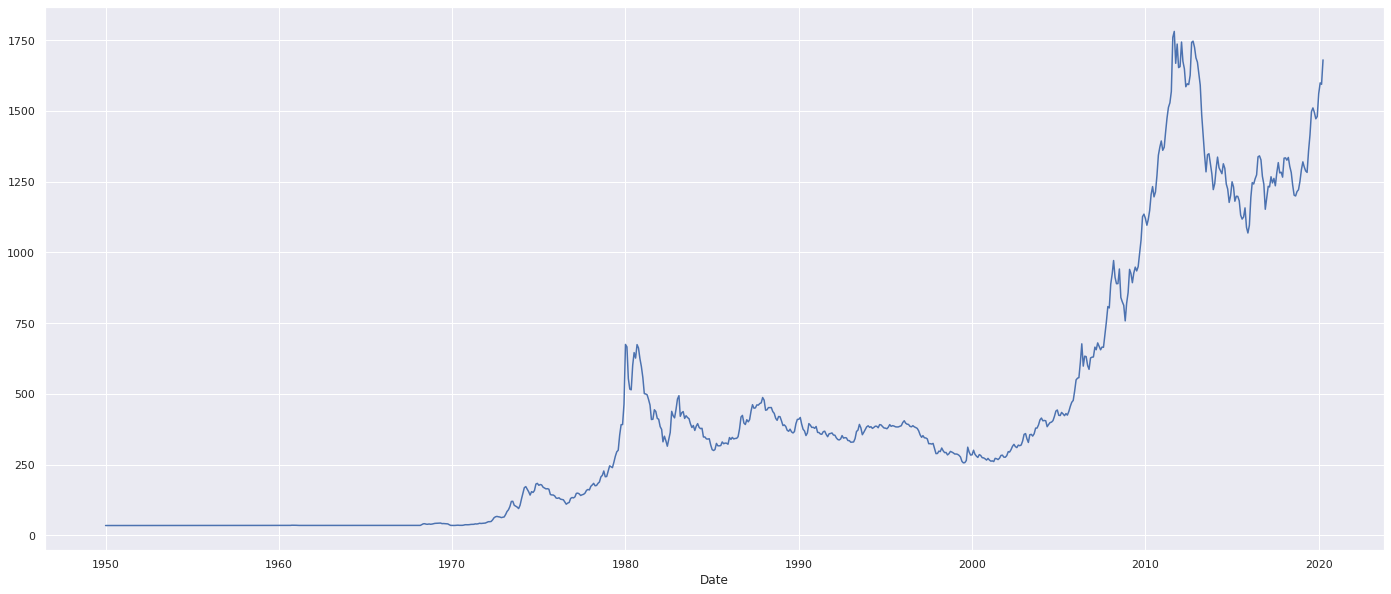

In [6]:
plt.figure(figsize=(24,10))
sns.lineplot(x=data.index,y=data)
plt.show()

### Checking for stationarity

In [0]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    plt.figure(figsize=(18,10))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

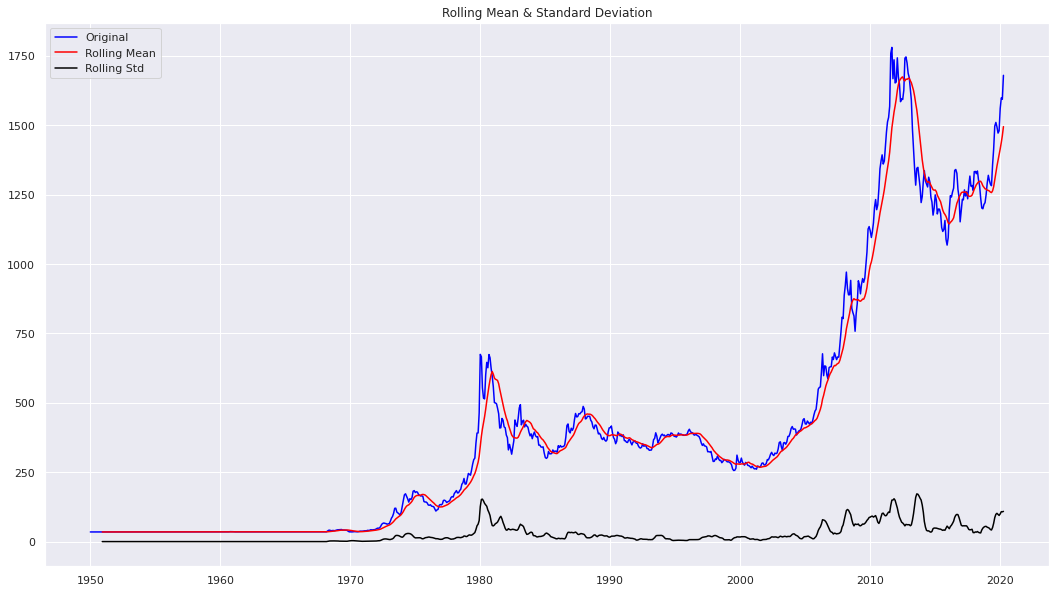

Results of Dickey-Fuller Test:
Test Statistic                   0.547530
p-value                          0.986248
#Lags Used                      11.000000
Number of Observations Used    832.000000
Critical Value (1%)             -3.438234
Critical Value (5%)             -2.865020
Critical Value (10%)            -2.568623
dtype: float64


In [8]:
test_stationarity(data)

- The above output shows that the series is not stationary since the test statistic is greater than all the critical values.

### Eliminating trend and seasonality

#### Log transform

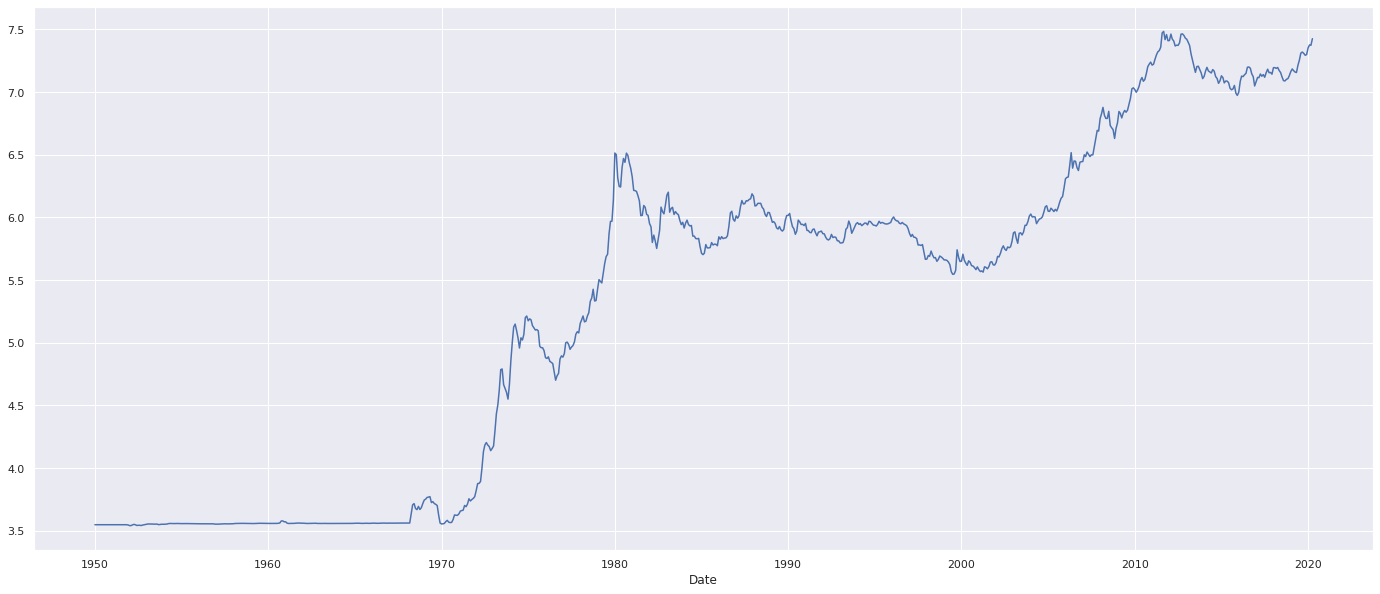

In [9]:
data_log = np.log(data)
data_log=data_log.replace([-np.inf,np.inf],0)
plt.figure(figsize=(24,10))
fig=sns.lineplot(x=data_log.index,y=data_log)
plt.show()

#### Moving average

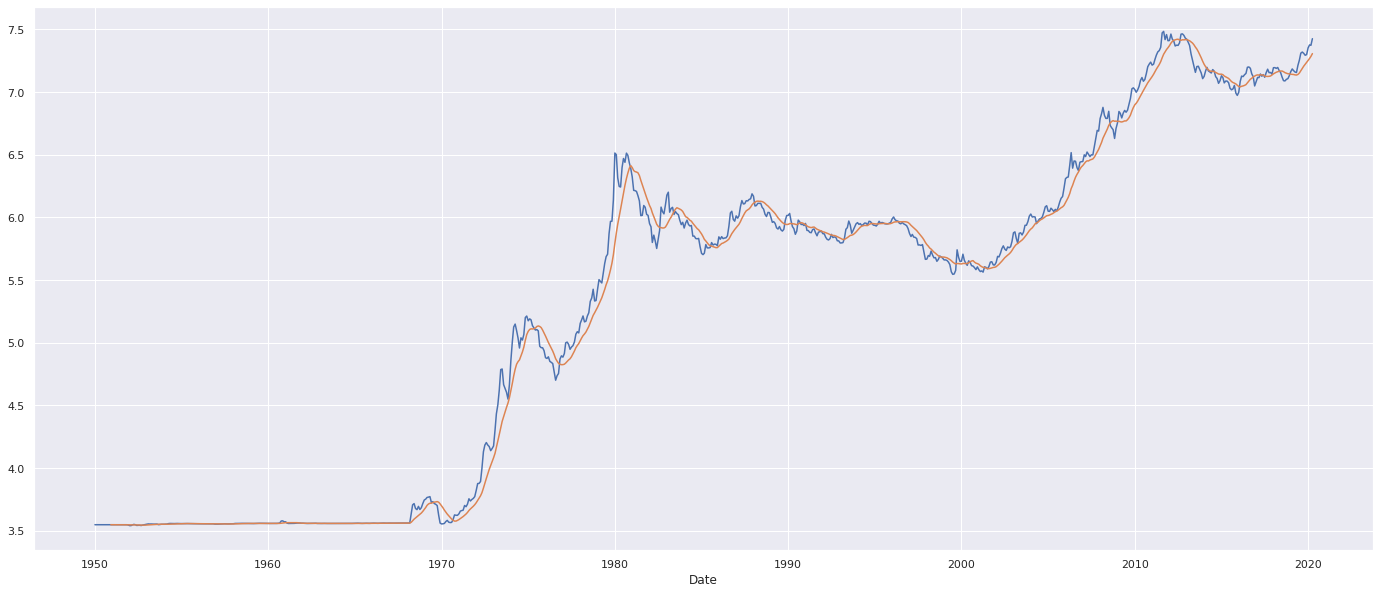

In [10]:
moving_avg = data_log.rolling(window=12).mean()
plt.figure(figsize=(24,10))
sns.lineplot(x=data_log.index,y=data_log)
sns.lineplot(x=moving_avg.index,y=moving_avg)
plt.show()

- The red line shows the rolling mean. Lets subtract this from the original series. Since we are taking average of last 12 values, rolling mean is not defined for first 11 values.

In [11]:
ts_log_moving_avg_diff = data_log - moving_avg
ts_log_moving_avg_diff.head(12)

Date
1950-01-01         NaN
1950-02-01         NaN
1950-03-01         NaN
1950-04-01         NaN
1950-05-01         NaN
1950-06-01         NaN
1950-07-01         NaN
1950-08-01         NaN
1950-09-01         NaN
1950-10-01         NaN
1950-11-01         NaN
1950-12-01   -0.000264
dtype: float64

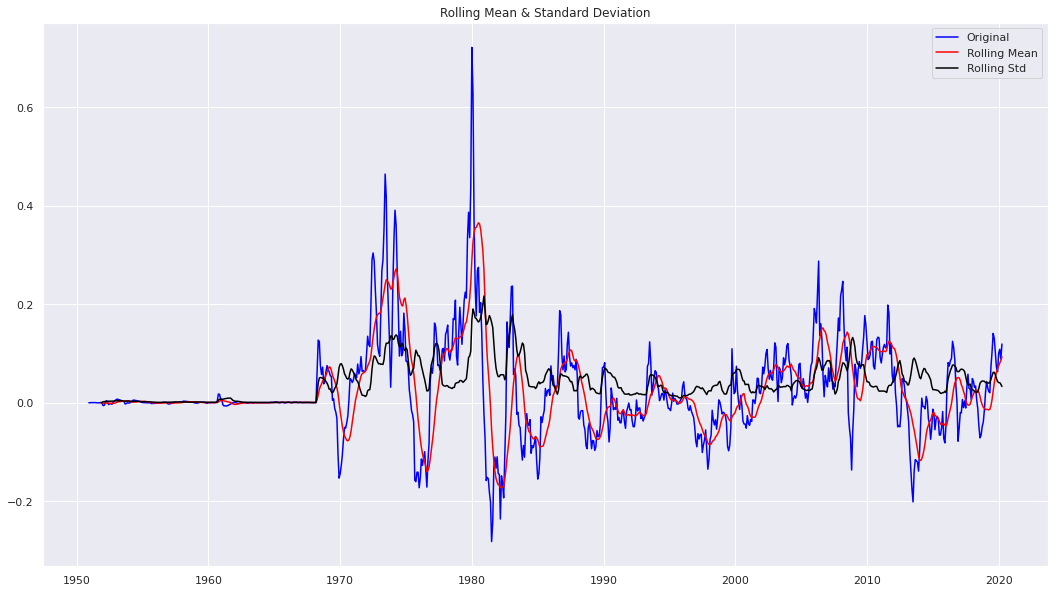

Results of Dickey-Fuller Test:
Test Statistic                -5.964592e+00
p-value                        2.001674e-07
#Lags Used                     1.100000e+01
Number of Observations Used    8.210000e+02
Critical Value (1%)           -3.438340e+00
Critical Value (5%)           -2.865067e+00
Critical Value (10%)          -2.568648e+00
dtype: float64


In [12]:
ts_log_moving_avg_diff.dropna(inplace=True)
test_stationarity(ts_log_moving_avg_diff)

- The test statistic is smaller than all the critical values, thus, the series is stationary even at 99% confidence interval.

#### Exponential moving average

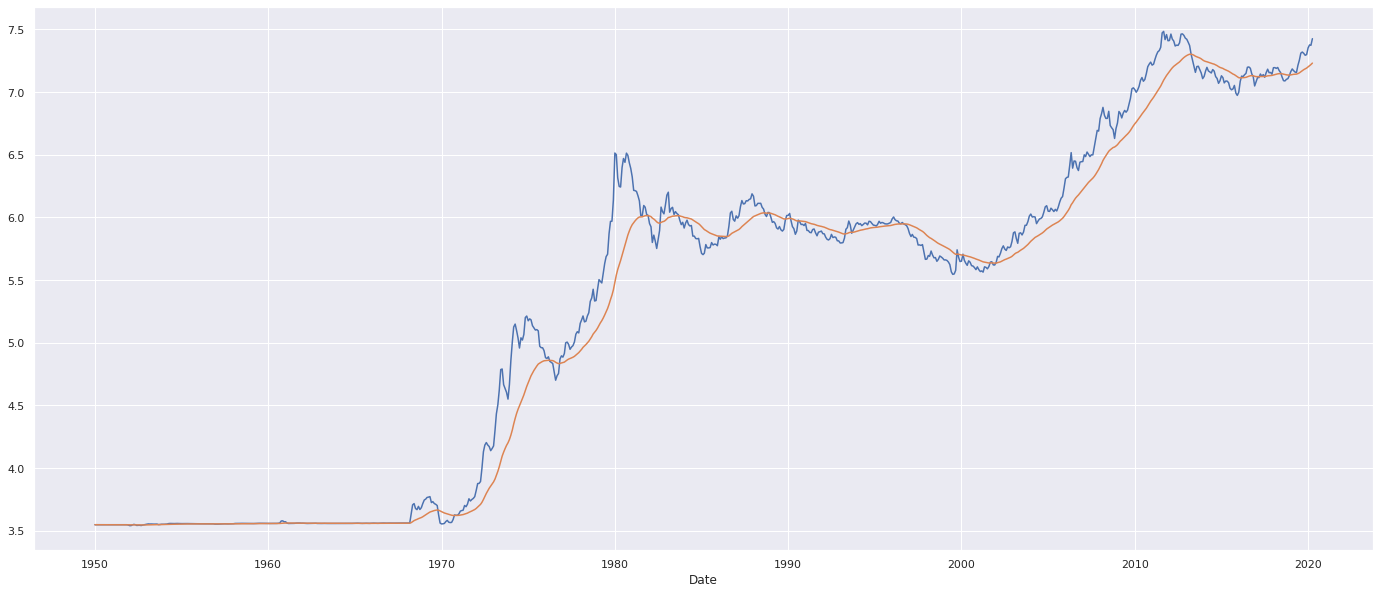

In [13]:
expwighted_avg = data_log.ewm(halflife=12).mean()
plt.figure(figsize=(24,10))
sns.lineplot(x=data_log.index,y=data_log)
sns.lineplot(x=expwighted_avg.index,y=expwighted_avg)
plt.show()

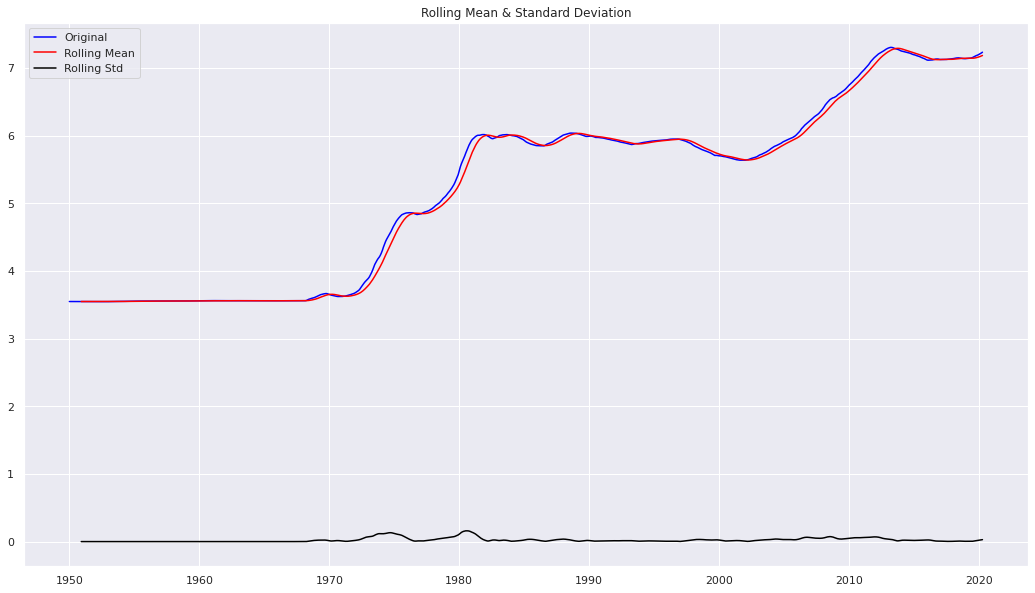

Results of Dickey-Fuller Test:
Test Statistic                  -0.280936
p-value                          0.928161
#Lags Used                      12.000000
Number of Observations Used    831.000000
Critical Value (1%)             -3.438244
Critical Value (5%)             -2.865024
Critical Value (10%)            -2.568625
dtype: float64


In [14]:
expwighted_avg.dropna(inplace=True)
test_stationarity(expwighted_avg)

- This looks like a much better series but it is still not stationary as the test statistic is greater than the all the critical values.

#### Differencing

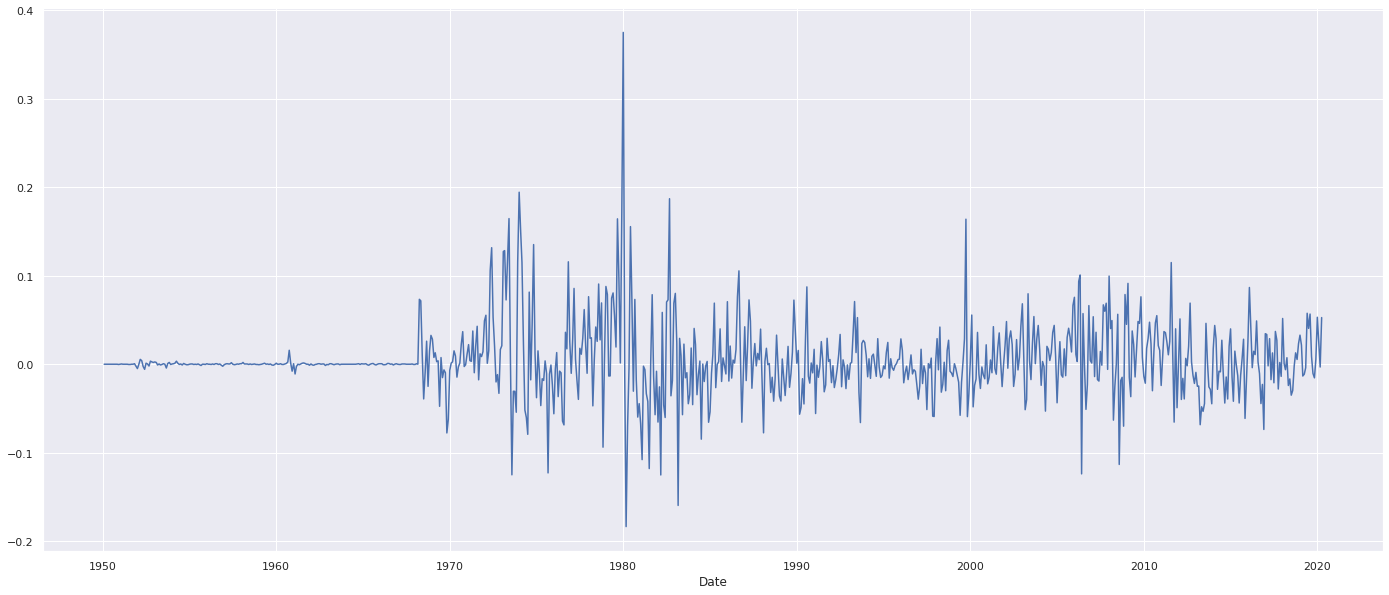

In [15]:
ts_log_diff = data_log - data_log.shift(1)
plt.figure(figsize=(24,10))
sns.lineplot(x=ts_log_diff.index,y=ts_log_diff)
plt.show()

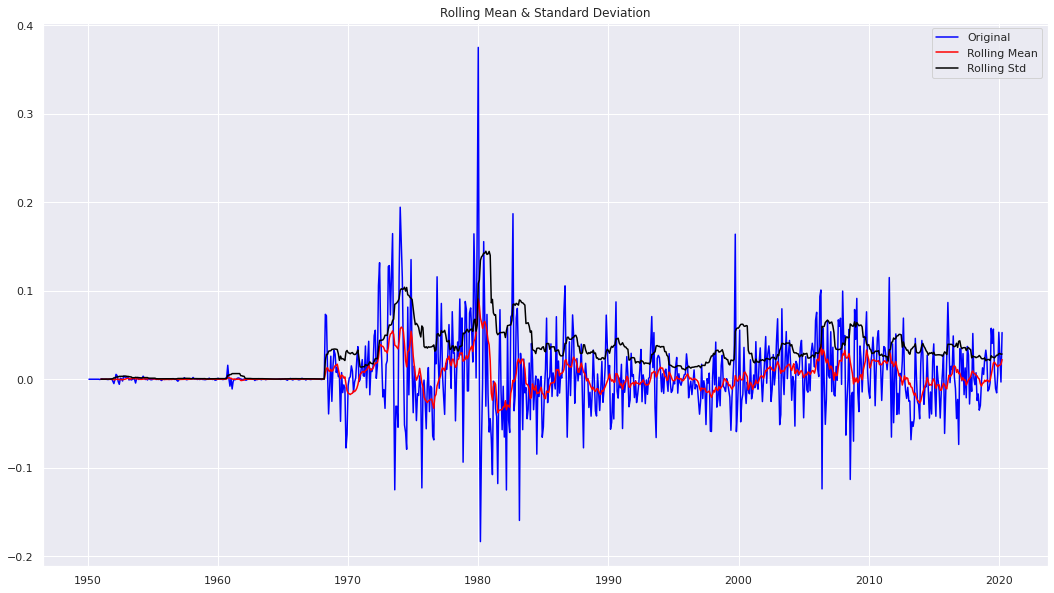

Results of Dickey-Fuller Test:
Test Statistic                -5.892853e+00
p-value                        2.896984e-07
#Lags Used                     1.700000e+01
Number of Observations Used    8.250000e+02
Critical Value (1%)           -3.438301e+00
Critical Value (5%)           -2.865050e+00
Critical Value (10%)          -2.568639e+00
dtype: float64


In [16]:
ts_log_diff=ts_log_diff.replace([-np.inf,np.inf],np.nan)
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff.dropna())

- The test statistic is smaller than all the critical values, thus, the series is stationary even at 99% confidence interval.
- We will be using this for our model building process.

#### Decomposing

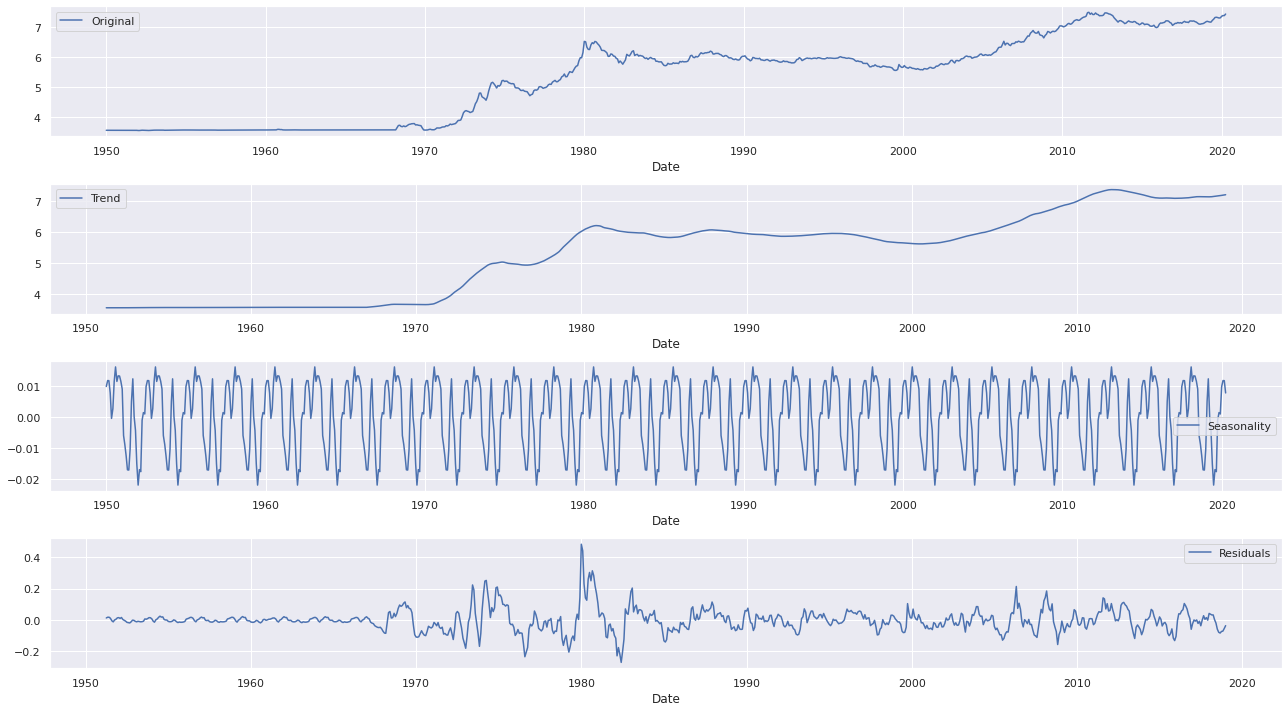

In [17]:
from statsmodels.tsa.seasonal import seasonal_decompose
data_log=data_log.replace([-np.inf,np.inf],np.nan)
data_log.dropna(inplace=True)
decomposition = seasonal_decompose(data_log,freq=30)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(18,10))
plt.subplot(411)
sns.lineplot(x=data_log.index,y=data_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
sns.lineplot(x=trend.index,y=trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
sns.lineplot(x=seasonal.index,y=seasonal, label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
sns.lineplot(x=residual.index,y=residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

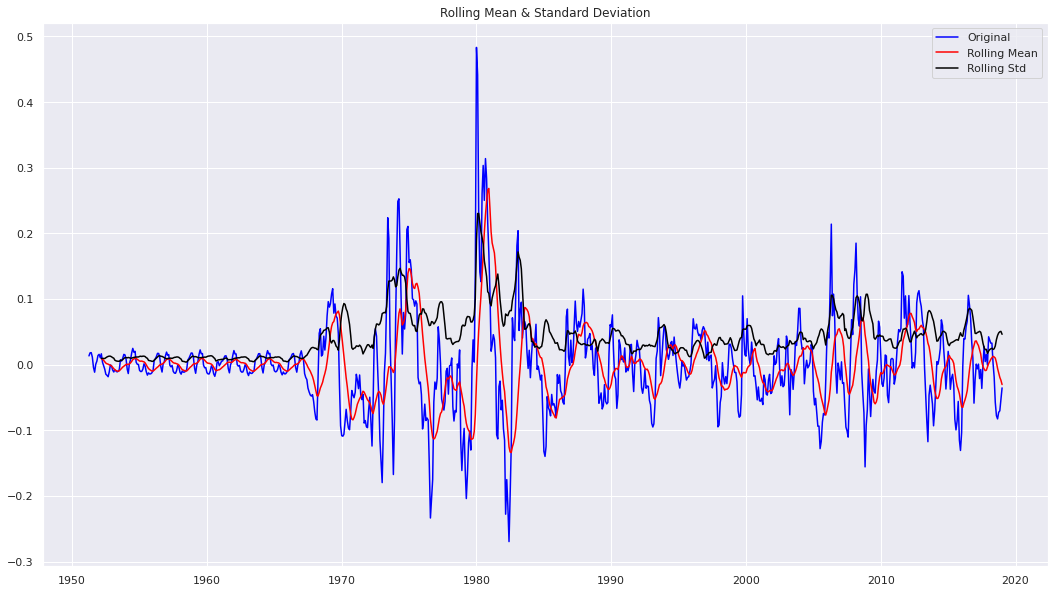

Results of Dickey-Fuller Test:
Test Statistic                -8.022250e+00
p-value                        2.061381e-12
#Lags Used                     1.600000e+01
Number of Observations Used    7.970000e+02
Critical Value (1%)           -3.438581e+00
Critical Value (5%)           -2.865173e+00
Critical Value (10%)          -2.568705e+00
dtype: float64


In [18]:
ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)
test_stationarity(ts_log_decompose)

- This is also a perfect stationary series.

###  Forecasting a Time Series

In [0]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf

In [20]:
lag_acf = acf(ts_log_diff, nlags=20)
lag_pacf = pacf(ts_log_diff, nlags=20, method='ols')

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


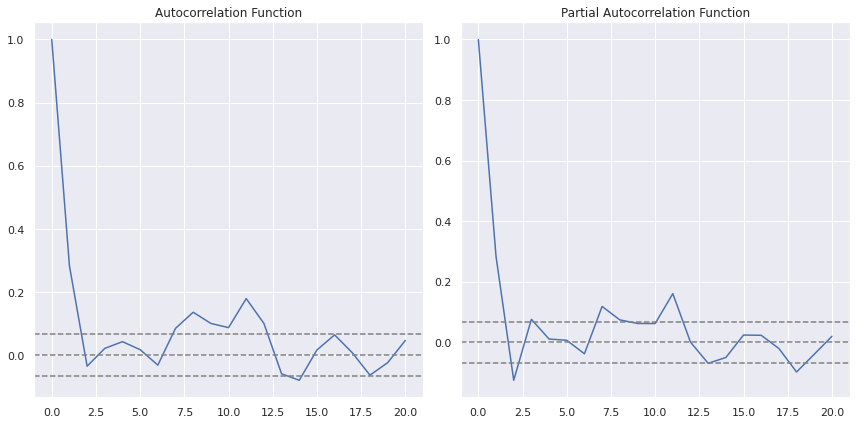

In [21]:
#Plot ACF: 
plt.figure(figsize=(12,6))
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')
#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

#### AR Model

In [0]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Text(0.5, 1.0, 'RSS: 1.2696')

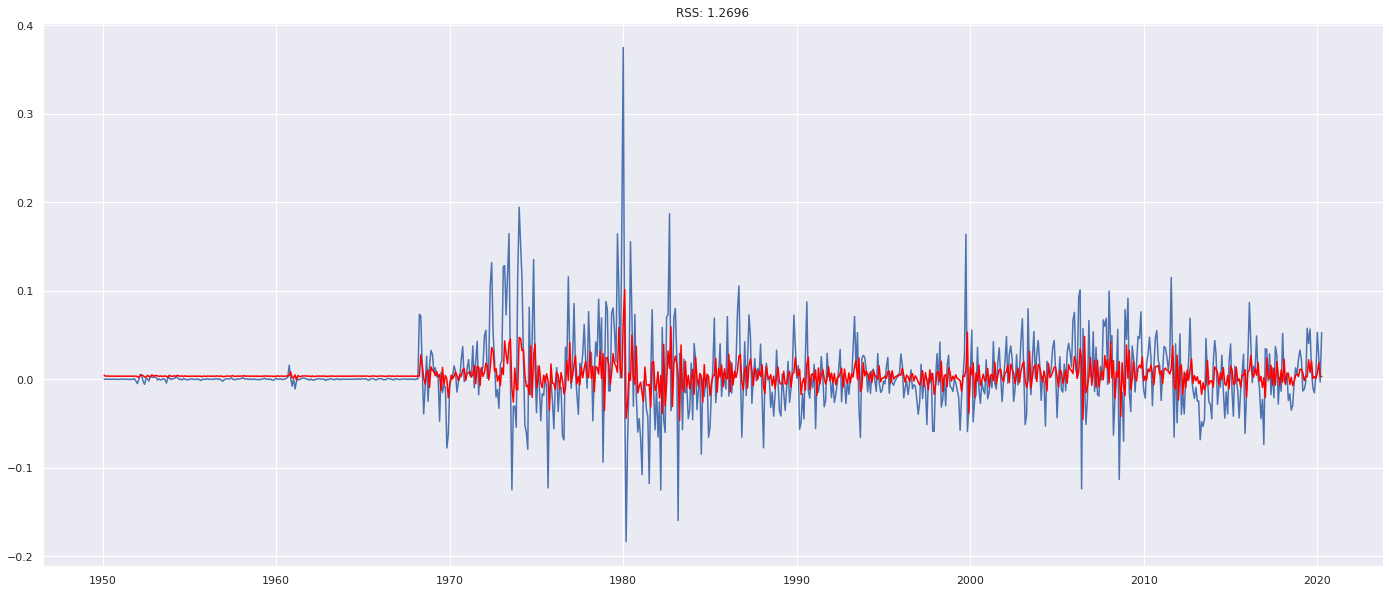

In [23]:
model = ARIMA(data_log, order=(3, 1, 0))  
results_AR = model.fit(disp=-1)  
plt.figure(figsize=(24,10))
plt.plot(ts_log_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-ts_log_diff)**2))

#### MA Model

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Text(0.5, 1.0, 'RSS: 1.2733')

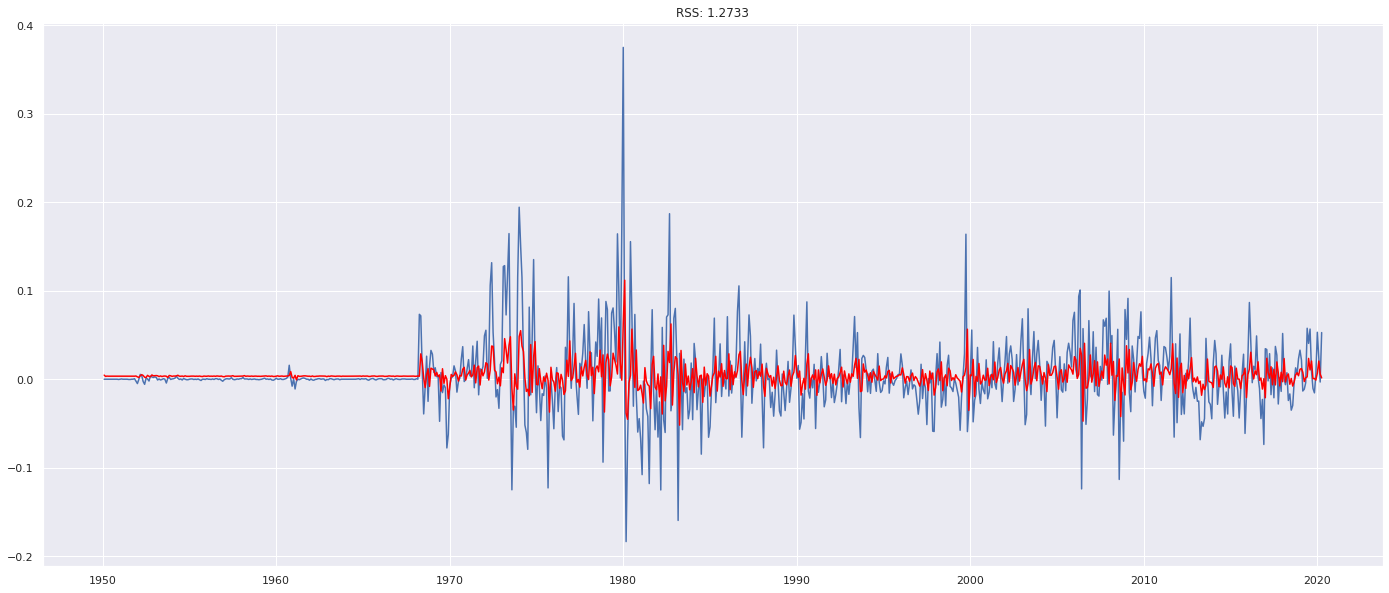

In [24]:
model = ARIMA(data_log, order=(0, 1, 1))  
results_MA = model.fit(disp=-1,start_params=(0,0))  
plt.figure(figsize=(24,10))
plt.plot(ts_log_diff)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-ts_log_diff)**2))

#### Combined Model - ARIMA

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Text(0.5, 1.0, 'RSS: 1.2694')

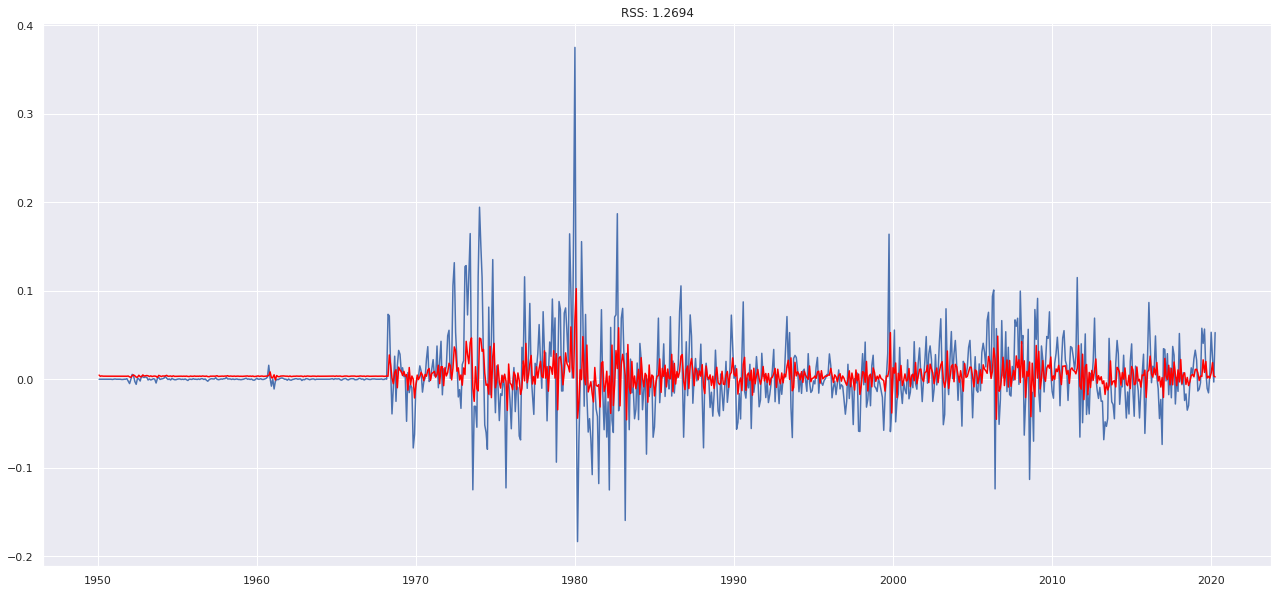

In [25]:
model = ARIMA(data_log, order=(3, 1, 1))  
results_ARIMA = model.fit(disp=-1)  
plt.figure(figsize=(22,10))
plt.plot(ts_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_log_diff)**2))

#### Taking it back to original scale

In [26]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
predictions_ARIMA_diff.head()

Date
1950-02-01    0.004624
1950-03-01    0.003315
1950-04-01    0.003732
1950-05-01    0.003452
1950-06-01    0.003415
dtype: float64

In [27]:
predictions_ARIMA_log = pd.Series(data_log, index=data_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff,fill_value=0)
predictions_ARIMA_log.tail()

Date
2019-12-01    7.301001
2020-01-01    7.359794
2020-02-01    7.395788
2020-03-01    7.377528
2020-04-01    7.429205
dtype: float64

Text(0.5, 1.0, 'RMSE: 8.8242')

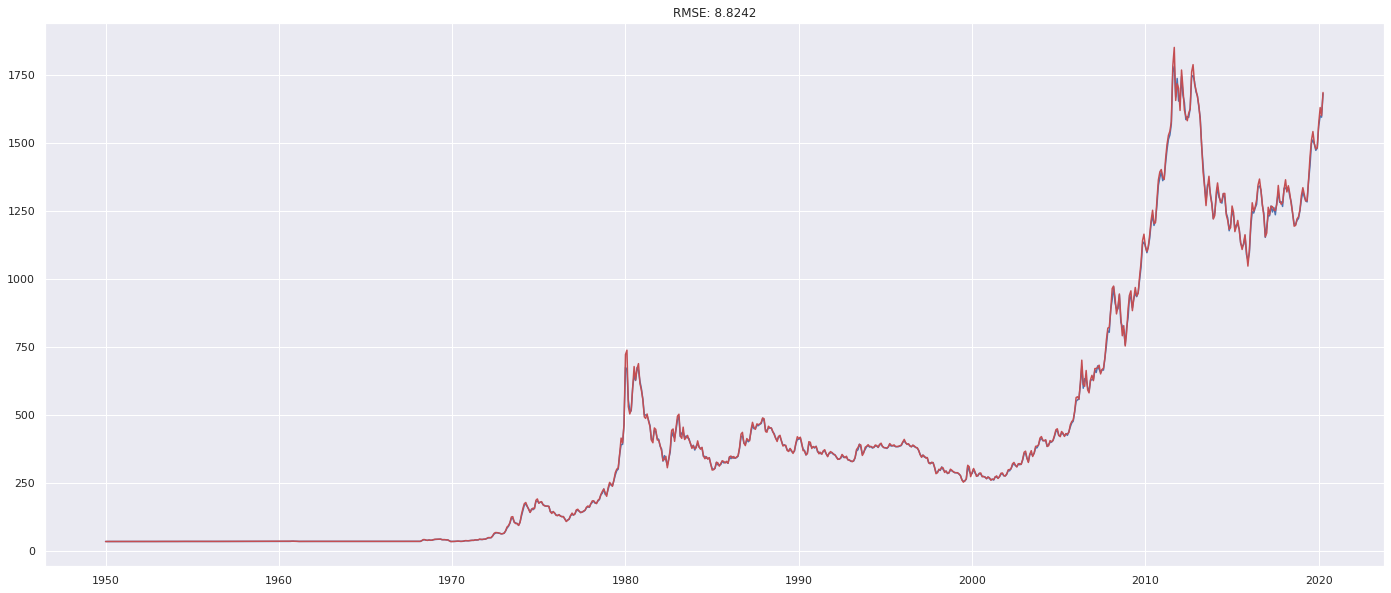

In [28]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.figure(figsize=(24,10))
plt.plot(data,color='b')
plt.plot(predictions_ARIMA,color='r')
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-data)**2)/len(data)))

- Thus we can see that our model is able to find the underlying pattern of the data and has traced the actual values pretty well.
- It's not necessary to provide a stationary series to ARIMA as it can deal with it, but we have done it for a better understanding.

#### Forecast for the coming year - ARIMA

In [0]:
till_april_21=[]
day="01"
date=data.index[-1]
year="2020"
for i in range(1,13):
    month=date.month
#   print("month::::",month)
    month=month+1
    month=str(month)
    if(int(month)<10):
        month="0"+month
    if(month==str(13)):
        month="01"
        year=str(int(year)+1)
    date=year+"-"+month+"-"+day
#   print("date::::",date)
    date=pd.to_datetime(date)
    till_april_21.append(date)

In [30]:
len(till_april_21)

12

In [0]:
# Using predict instead of forecast
#temp=results_ARIMA.predict(start=len(data),end=len(data)+len(till_april_21)-1)

In [32]:
till_april_21=pd.Series(results_ARIMA.forecast(steps=12)[0],index=till_april_21)
# Using predict instead of forecast
#till_april_21=temp
#till_april_21[0]=predictions_ARIMA_log[-1]+till_april_21[0]
#till_april_21=till_april_21.cumsum()
till_april_21.tail()

2020-12-01    7.484319
2021-01-01    7.488980
2021-02-01    7.493606
2021-03-01    7.498232
2021-04-01    7.502860
dtype: float64

In [0]:
predictions=predictions_ARIMA_log[-16:].append(till_april_21)
predictions=np.exp(predictions)

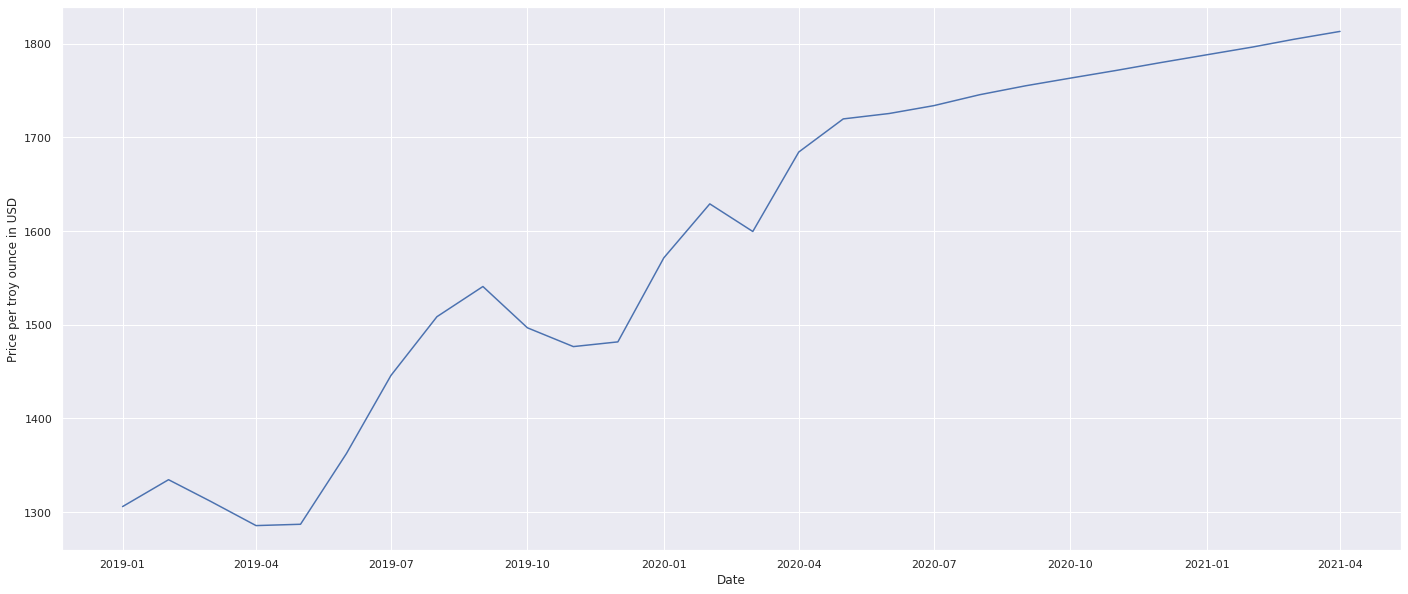

In [34]:
plt.figure(figsize=(24,10))
fig=sns.lineplot(x=predictions.index,y=predictions)
fig.set(xlabel='Date',ylabel='Price per troy ounce in USD')
plt.show()

- According to the model the prices will now stabilize and won't increase sharply.
- They are expected to stay between 1700-1800 USD per troy ounce.
- The model suggests that the prices wont't fall in the coming year but they won't increase much as well.
- A point to note here is that the forecasts represent the average values over the timeperiod in future not the exact values.
- The problem with ARIMA model here is that it cannot capture the seasonal component and thus predicts average values or basically captures the trend.



#### Forecast for the coming decade - ARIMA

In [0]:
till_april_30=[]
day="01"
date=data.index[-1]
year="2020"
for i in range(1,121):
    month=date.month
#   print("month::::",month)
    month=month+1
    month=str(month)
    if(int(month)<10):
        month="0"+month
    if(month==str(13)):
        month="01"
        year=str(int(year)+1)
    date=year+"-"+month+"-"+day
#   print("date::::",date)
    date=pd.to_datetime(date)
    till_april_30.append(date)

In [36]:
len(till_april_30)

120

In [0]:
till_april_30=pd.Series(results_ARIMA.forecast(steps=120)[0],index=till_april_30)

In [0]:
predictions=predictions_ARIMA_log.append(till_april_30)
predictions=np.exp(predictions)

In [0]:
# Using predict instead of forecast
#temp=results_ARIMA.predict(start=len(data),end=len(data)+len(till_april_30)-1)

In [0]:
# Using predict instead of forecast
#till_april_30=temp
#till_april_30[0]=predictions_ARIMA_log[-1]+till_april_30[0]
#till_april_30=till_april_30.cumsum()
#till_april_30.tail()

In [0]:
predictions=predictions_ARIMA_log.append(till_april_30)
predictions=np.exp(predictions)

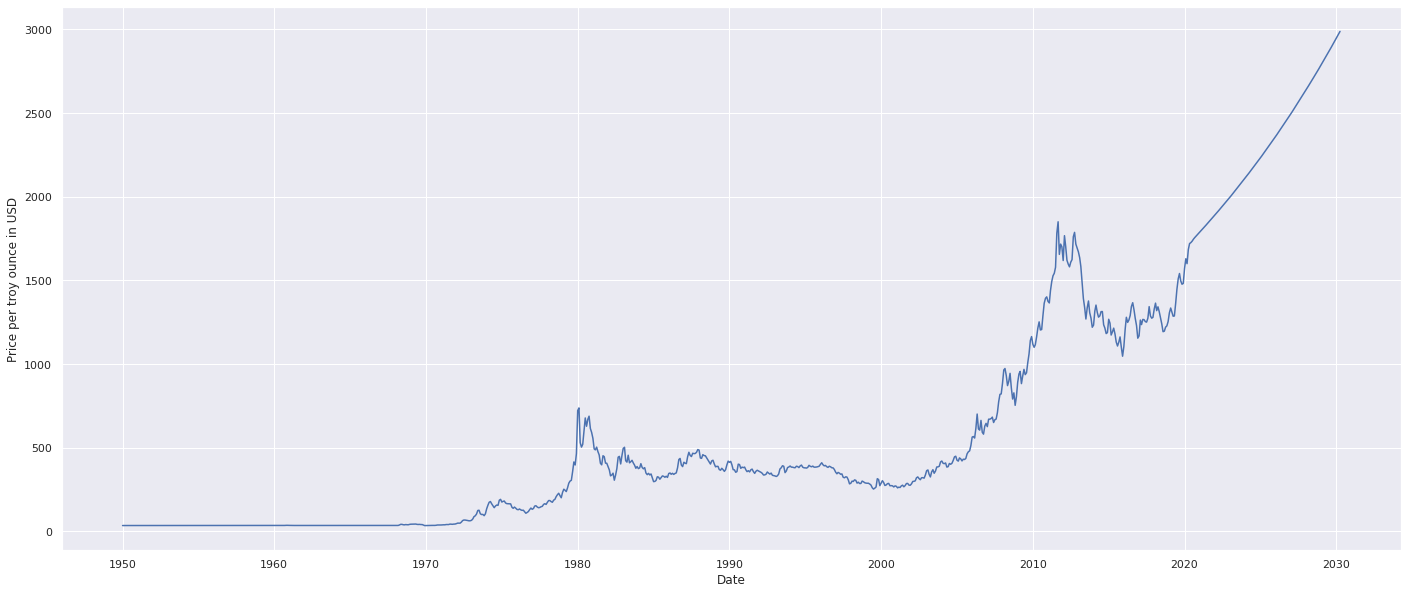

In [42]:
plt.figure(figsize=(24,10))
fig=sns.lineplot(x=predictions.index,y=predictions)
fig.set(xlabel='Date',ylabel='Price per troy ounce in USD')
plt.show()

- According to the model the prices will increase on an average.
- They are expected to stay around 3000 USD per troy ounce at the start of 2030.
- A point to note here is that the forecasts represent the average values over the timeperiod in future not the exact values.
- The problem with ARIMA model here is that it cannot capture the seasonal component and thus predicts average values or basically captures the trend.

#### Final Model - SARIMAX

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Text(0.5, 1.0, 'RMSE: 24.1868')

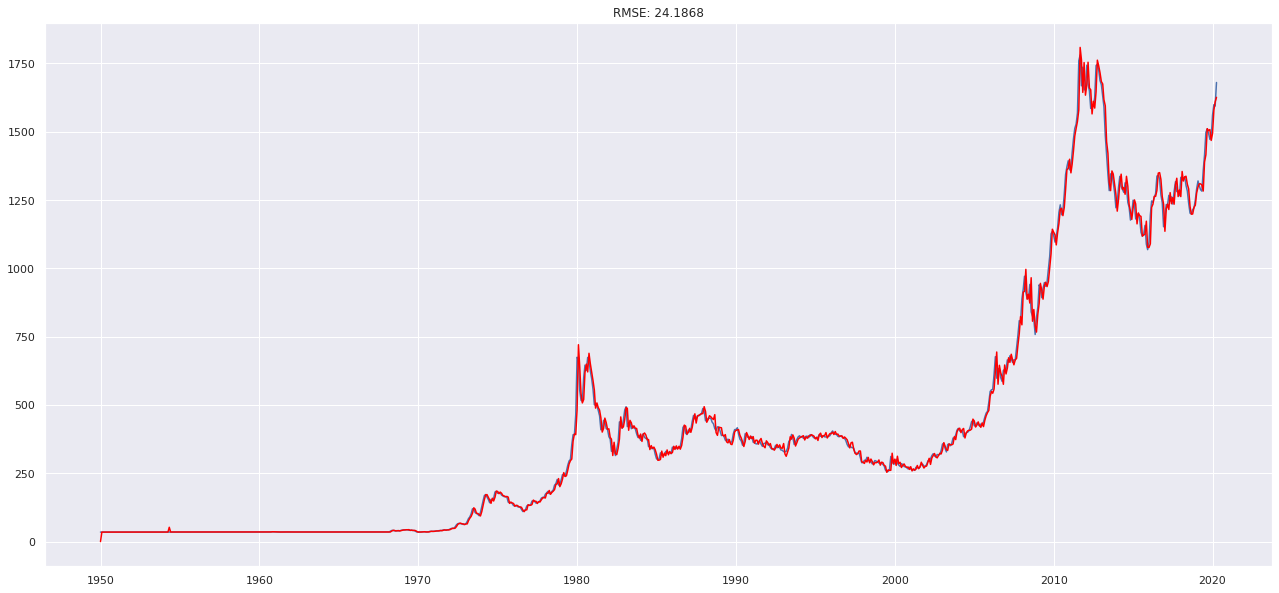

In [55]:
model = SARIMAX(data, order=(3, 1, 1),seasonal_order=(3,1,1,52))  
results_SARIMAX = model.fit(disp=-1)  
plt.figure(figsize=(22,10))
plt.plot(data)
plt.plot(results_SARIMAX.fittedvalues, color='red')
plt.title('RMSE: %.4f'% np.sqrt(sum((results_SARIMAX.fittedvalues-data)**2)/len(data)))

- Though this model has a lower RMSE than ARIMA model but has captured the seasonal component as well and thus, will make more accurate forecasts.

#### Forecast for the coming year - SARIMAX

In [0]:
till_april_21=[]
day="01"
date=data.index[-1]
year="2020"
for i in range(1,13):
    month=date.month
#   print("month::::",month)
    month=month+1
    month=str(month)
    if(int(month)<10):
        month="0"+month
    if(month==str(13)):
        month="01"
        year=str(int(year)+1)
    date=year+"-"+month+"-"+day
#   print("date::::",date)
    date=pd.to_datetime(date)
    till_april_21.append(date)

In [0]:
till_april_21=pd.Series(results_SARIMAX.forecast(steps=120),index=till_april_21)
till_april_21=data[-16:].append(till_april_21)

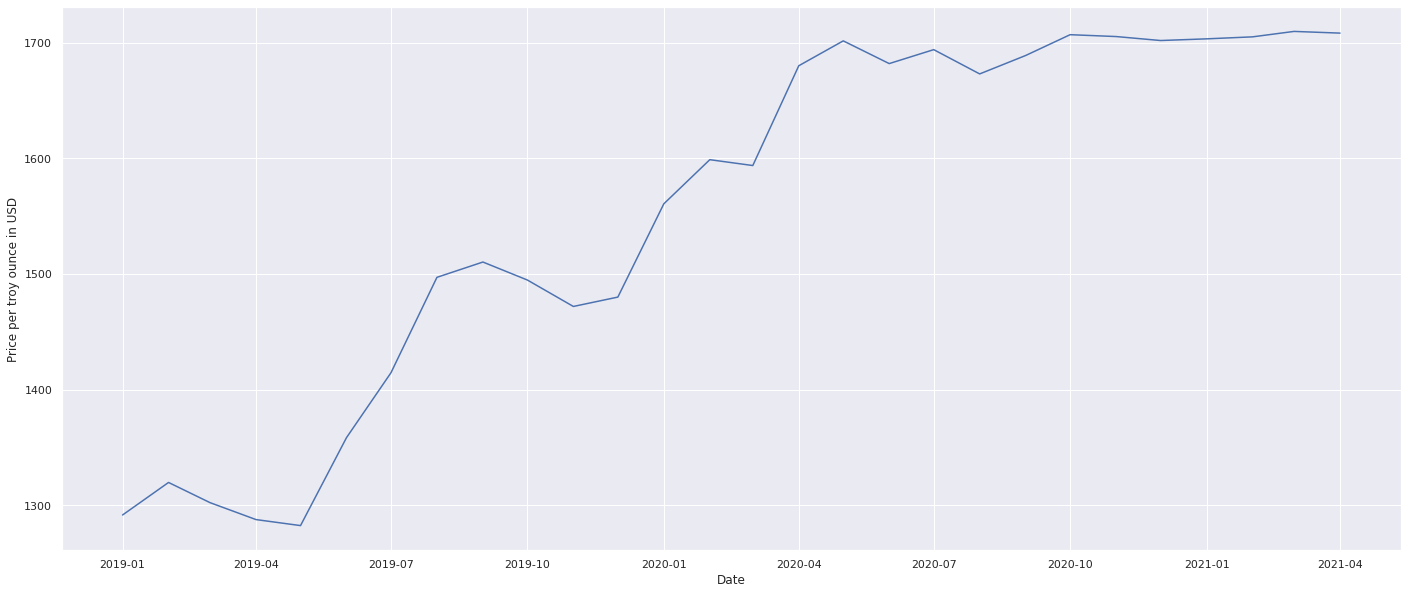

In [58]:
plt.figure(figsize=(24,10))
fig=sns.lineplot(x=till_april_21.index,y=till_april_21)
fig.set(xlabel='Date',ylabel='Price per troy ounce in USD')
plt.show()

- So our model suggests that gold prices are expected to stabilise for the coming year i.e no major rise or fall will be reported.
- If we focus on the coming two months, we can see that prices can go down a bit, but no major drop in the prices will be seen.

#### Forecast for the coming decade - SARIMAX

In [0]:
till_april_30=[]
day="01"
date=data.index[-1]
year="2020"
for i in range(1,121):
    month=date.month
#   print("month::::",month)
    month=month+1
    month=str(month)
    if(int(month)<10):
        month="0"+month
    if(month==str(13)):
        month="01"
        year=str(int(year)+1)
    date=year+"-"+month+"-"+day
#   print("date::::",date)
    date=pd.to_datetime(date)
    till_april_30.append(date)

In [0]:
till_april_30=pd.Series(results_SARIMAX.forecast(steps=120),index=till_april_30)
till_april_30=data.append(till_april_30)

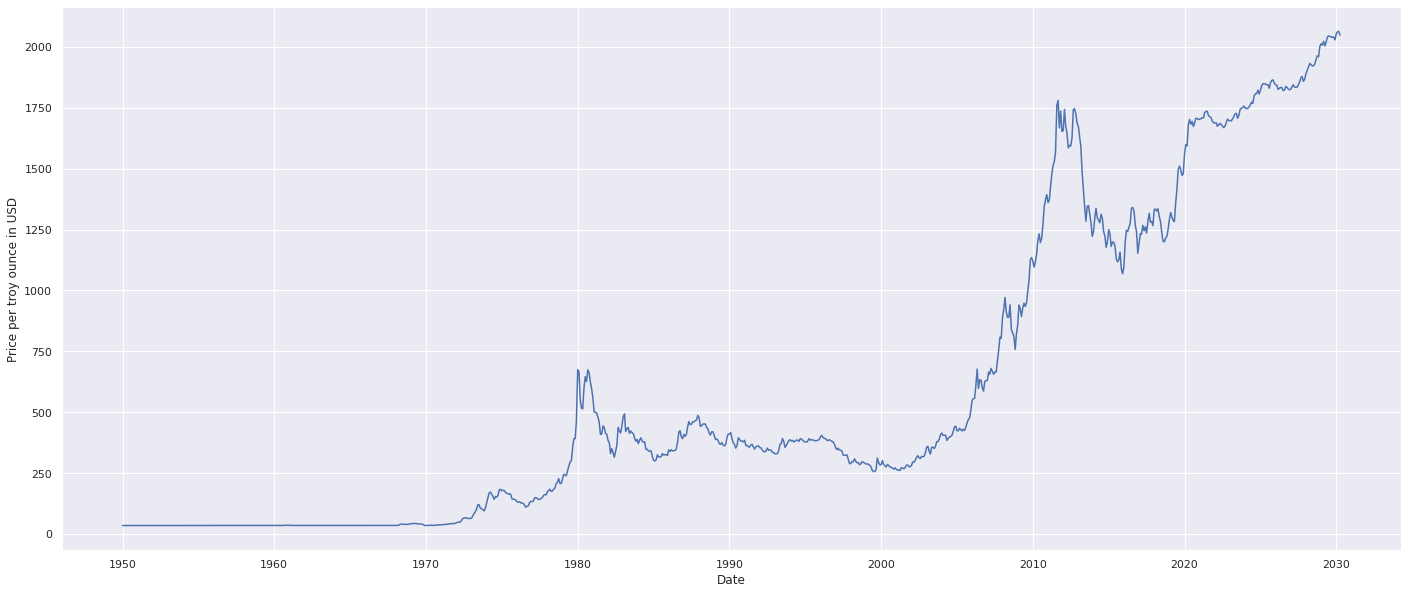

In [61]:
plt.figure(figsize=(24,10))
fig=sns.lineplot(x=till_april_30.index,y=till_april_30)
fig.set(xlabel='Date',ylabel='Price per troy ounce in USD')
plt.show()

- Our model predicts that gold prices will start to rise again around 2023, till then they will fluctuate and even fall.
- By the start of 2030, the price in USD for a troy ounce of gold is expected to be about 2000 USD.